# Modèle de Classification detection d'anomalies

https://blog.floydhub.com/introduction-to-anomaly-detection-in-python/

## 1. Librairies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 2. Dataset

In [3]:
# nom de fichier et chemin relatif
filename = 'merge_clean_metrics_dataset.csv'
path = '../data/metrics/'
# création d'un dataframe à partir du csv de données
df = pd.read_csv(path+filename, index_col=0)
df.head(2)

,type_modules,name_counters_modules,value_counters_modules,name_connected_operators,level_connected_operators,source_events,timestamp,criticality_events,identification_events,varnishLevelsTargetvolume,varnishLevelsTotalvolume
0,Varnish Printer,3D Varnish Counter,1792992,Viktor,Operator,NaN,2022-04-15 05:55:06.678000+00:00,0,0,36192,100000
1,iFoil,Total Pages Counter,22881,Viktor,Operator,NaN,2022-04-15 05:55:06.678000+00:00,0,0,36192,100000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3546276 entries, 0 to 3546275
Data columns (total 11 columns):
 #   Column                     Dtype 
---  ------                     ----- 
 0   type_modules               object
 1   name_counters_modules      object
 2   value_counters_modules     int64 
 3   name_connected_operators   object
 4   level_connected_operators  object
 5   source_events              object
 6   timestamp                  object
 7   criticality_events         int64 
 8   identification_events      int64 
 9   varnishLevelsTargetvolume  int64 
 10  varnishLevelsTotalvolume   int64 
dtypes: int64(5), object(6)
memory usage: 324.7+ MB


## 3. Ifoil dataframe

In [5]:
df.type_modules.unique()

array(['Varnish Printer', 'iFoil'], dtype=object)

In [35]:
df.source_events.unique()

array([nan, 'PLC', 'iFoil', 'Kernel', 'ICB n°5', 'RCB n°1', 'RCB n°2',
       'RCB n°3', 'ICB n°4', 'ICB n°7', 'ICB n°8', 'ICB n°2', 'ICB n°1',
       'ICB n°6', 'Pilot'], dtype=object)

In [13]:
ifoil_df = df[df.type_modules == 'iFoil']
ifoil_df = df[df.source_events == 'iFoil']

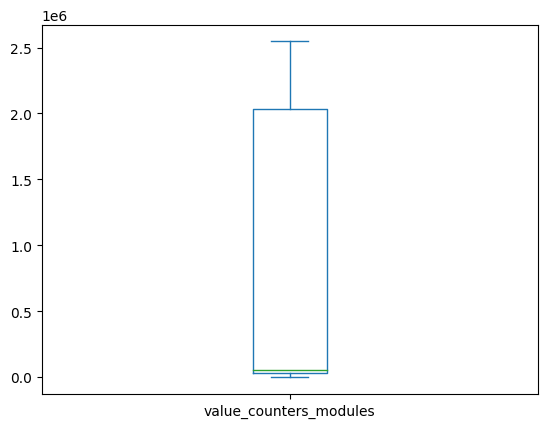

In [34]:
# Generate a Boxplot
ifoil_df['value_counters_modules'].plot(kind='box')
plt.show()

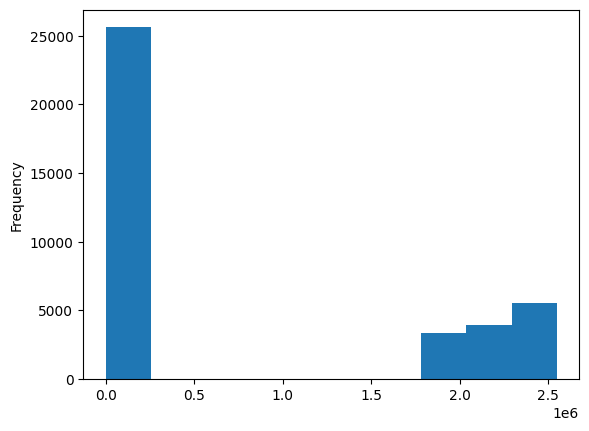

In [30]:
# Generate a Histogram plot
ifoil_df['value_counters_modules'].plot(kind='hist')
plt.show()

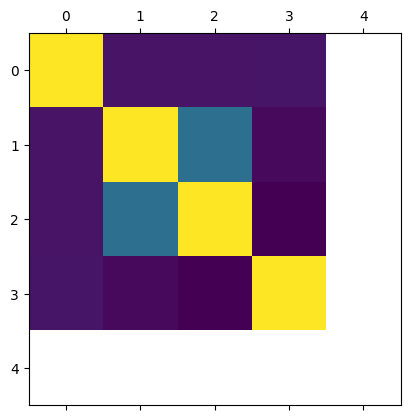

In [31]:
corr_matrix = ifoil_df.corr(numeric_only=True)
plt.matshow(corr_matrix)
plt.show()

ValueError: x and y must be the same size

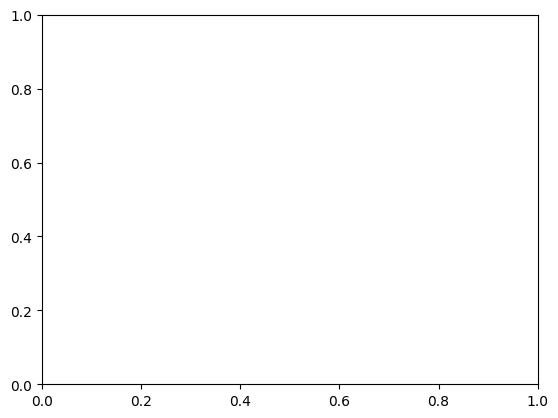

In [25]:
# Convert the salary values to a numpy array
salary_raw = df['value_counters_modules'].values
# For compatibility with the SciPy implementation
salary_raw = salary_raw.reshape(-1, 1)
salary_raw = salary_raw.astype('float64')
# Import kmeans from SciPy
from scipy.cluster.vq import kmeans
from scipy import cluster
# Specify the data and the number of clusters to kmeans()
centroids, avg_distance = kmeans(salary_raw, 4)
# Get the groups (clusters) and distances
groups, cdist = cluster.vq.vq(salary_raw, centroids)
plt.scatter(salary_raw, np.arange(0,100), c=groups)
plt.xlabel('value_counters_modules')
plt.ylabel('criticality_events')
plt.show()